## Ejercicio 3

### método asignado en la planilla de grupos: MONTECARLO

Se está diseñando un web service, el cual cada vez que es invocado consulta a una base de datos. Se estima que el tiempo que transcurre entre cada llamada al servicio se puede modelar según una distribución exponencial con media =4 segundos

Se debe decidir la arquitectura de base de datos a utilizar entre las dos siguientes:
1. Utilizar 2 bases de datos distribuidas.
Con probabilidad p=0.6 las solicitudes son atendidas por la base 1 y con probabilidad q=1-p son atendidos por la base de datos 2.
El tiempo que demora cada base de datos en atender una solicitud sigue una distribución exponencial con medias, 1=0,7 seg y 2=1 seg respectivamente.
2. Utilizar 1 base de datos central.
En este caso la demora en resolver una solicitud sigue una distribución exponencial con =0,8 segundos. 

Se suponen despreciables cualquier otro tiempo en el sistema.
Simular para cada opción 100000 solicitudes procesadas, determinando:
- El tiempo medio de espera entre que la solicitud llega y puede ser procesada (suponer que ninguna conexión cae
por timeout).
- La fracción de las solicitudes que no esperaron para ser procesadas.
- La opción 1 es más costosa que la segunda opción y la empresa sólo acepta realizar la inversión si el tiempo medio que demora en resolver cada solicitud (tiempo en fila + tiempo de procesamiento) es como mínimo 50% menor
que la opción 2. ¿Qué solución le recomienda?

Proponer otras frecuencias de arribos de solicitudes y comprar los resultados obtenidos.

### Imports

In [1]:
from MixMax import MixmaxRNG
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

### Constantes

In [2]:
# tiempo entre llamadas al servicio
MEAN_ARRIVAL_CALL = 4 

# BASE DE DATOS 1
MEAN_PROCESSING_TIME_DB1 = 0.7  # Tiempo medio de procesamiento en la base de datos 1
MEAN_PROCESING_TIME_DB2 = 1.0  # Tiempo medio de procesamiento en la base de datos 2
PROBABILITY_DB1 = 0.6 # Probabilidad de ser atendido por la base de datos 1 (en la opcion donde hay dos bases de datos distribuidas)

# BASE DE DATOS 2
# Demora en resolver una solicitud -> distribución exponencial con =0,8 segundos
MEAN_PROCESSING_TIME_CENTRAL_DB = 0.8

# semillas
# semilla de arrivos de solicitudes
SEED_ARRIVALS = 1235
# semilla de tiempo de procesamiento de la base de datos
SEED_PROCESING_TIME = 782
# semilla para calculos de probabilidad
SEED = 987654321

TOTAL_REQUEST = 100000

### Código

In [3]:
class DistribuitedDataBase:
    def __init__(self, mean_process_time_d1, mean_process_time_d2, seed, probability_d1):
        self.mean_process_time_d1 = mean_process_time_d1
        self.mean_process_time_d2 = mean_process_time_d2
        self.probability_d1 = probability_d1
        self.pending_calls_d1_queue = deque() # Cola FIFO para la base de datos 1
        self.pending_calls_d2_queue = deque() # Cola FIFO para la base de datos 2
        self.random = MixmaxRNG(seed)
        # Current time acumulan arrival + process time (se maneja distinto en cada base de datos)
        self.current_time_d1 = 0
        self.current_time_d2 = 0
        self.arrival_times = [] 
        self.processing_times = [] 
        self.wait_times = []

    # Agrega las requests que llegan a la cola de la base de datos correspondiente
    def add_request(self, arrival_time, process_time):
        # Guardamos la informacion de tiempos de arrivo y de procesamiento
        self.arrival_times.append(arrival_time)
        self.processing_times.append(process_time)
       
        if self.random.generate_number() < self.probability_d1:  
            self.pending_calls_d1_queue.append((arrival_time, process_time))
        else:  
             self.pending_calls_d2_queue.append((arrival_time, process_time))    

    def process_requests(self):
        self.process_requests_d1()
        self.process_requests_d2()

    def process_requests_d1(self):
        # Evaluo todas las requests generadas en la base 1
        while self.pending_calls_d1_queue:
            arrival_time, process_time = self.pending_calls_d1_queue.popleft()
            
            # Si llega en un tiempo posterior al actual, ya termino de procesar la anterior, no espera
            if self.current_time_d1 < arrival_time:
                    self.wait_times.append(0)
                    self.current_time_d1 = arrival_time
            else:
                self.wait_times.append(self.current_time_d1 - arrival_time)

            # Actualizamos el current time de la base 1
            self.current_time_d1 += process_time
    
    def process_requests_d2(self):
        # Evaluo todas las requests generadas en la base 2
        while self.pending_calls_d2_queue:
            arrival_time, process_time = self.pending_calls_d2_queue.popleft()
            
            # Si llega en un tiempo posterior al actual, ya termino de procesar la anterior, no espera
            if self.current_time_d2 < arrival_time:
                    self.wait_times.append(0)
                    self.current_time_d2 = arrival_time
            else:
                self.wait_times.append(self.current_time_d2 - arrival_time)
            
            # Actualizamos el current time de la base 2
            self.current_time_d2 += process_time

    # Obtenemos los tiempos de arrivos, procesamiento y espera
    def get_info(self):
        return self.arrival_times, self.processing_times, self.wait_times

In [4]:
class CentralDataBase:
    def __init__(self, mean_process_time):
        self.mean_process_time = mean_process_time
        self.pending_calls_queue = deque()  # Cola FIFO
        self.arrival_times = [] 
        self.processing_times = [] 
        self.wait_times = []
        self.current_time = 0 # Tiene en cuenta los tiempos de llegada + procesamiento

    # Almacenamos la request en la cola y nos guardamos la info necesaria
    def add_request(self, arrival_time, process_time):
        self.arrival_times.append(arrival_time)
        self.processing_times.append(process_time)
        self.pending_calls_queue.append((arrival_time, process_time))

    def process_requests(self):
        # Evaluo todas las requests generadas para la base de datos central
        while self.pending_calls_queue:
            # Me quedo con la siguiente en fila
            arrival_time, process_time = self.pending_calls_queue.popleft()
            # Si la siguiente a procesar llega en un tiempo mayor al actual, se procesa
            # current time = arrival + process time anterior --> si arrival > current --> ya procesó la anterior
            if self.current_time < arrival_time:
                    self.wait_times.append(0)
                    self.current_time = arrival_time
            # Llega antes del tiempo actual, espera
            else:
                self.wait_times.append(self.current_time - arrival_time)
            
            # Actualizo current time
            self.current_time += process_time
            
    # Obtenemos los tiempos de arrivos, procesamiento y espera
    def get_info(self):
        return self.arrival_times, self.processing_times, self.wait_times


In [5]:
class WebService:
    def __init__(self, seed, seed_arrivals, seed_process, TOTAL_REQUEST, mean_time_between_calls, mean_process_times_list, centralDB = True, probability_d1 = 0):
        self.total_requests = TOTAL_REQUEST
        self.mean_time_between_calls = mean_time_between_calls
        self.mean_process_time_d1 = mean_process_times_list[0]
        self.random = MixmaxRNG(seed)
        self.cetral_data_base = centralDB
        self.probability_d1 = probability_d1
        self.random_arrival = MixmaxRNG(seed_arrivals)
        self.random_processing = MixmaxRNG(seed_process)

        if self.cetral_data_base:
            self.dataBase = CentralDataBase(self.mean_process_time_d1)
        else:
            self.mean_process_time_d2 = mean_process_times_list[1]
            self.dataBase = DistribuitedDataBase(self.mean_process_time_d1, self.mean_process_time_d2, seed, self.probability_d1)

    def exponential_time(self, random_num, mean):
         return -(mean * np.log(1 - random_num))

    # Generar llamadas, luego cada base de datos se encarga de procesarlas
    def generate_and_process_requests(self):
        arrival_time = 0

        for _ in range(self.total_requests):
            # Genero todas las requests, van llegando en orden ya se van sumando los tiempos   
            arrival_time += self.exponential_time(self.random_arrival.generate_number(), self.mean_time_between_calls)            
            process_time = self.exponential_time(self.random_processing.generate_number(), self.mean_process_time_d1)
            self.dataBase.add_request(arrival_time, process_time)

        # Procesamos las llamadas
        self.dataBase.process_requests()
        
    # Obtenemos los tiempos de arrivos, procesamiento y espera de la base de datos actual
    def get_info_db(self):
        return self.dataBase.get_info()
    
    def get_total_requests(self):
        return self.total_requests

### Simulación 

In [6]:
def print_webservice_data(webService: WebService, header):
    _, processing_times, wait_times = webService.get_info_db()
    total_requests = webService.get_total_requests()

    # tiempo medio de espera
    mean_waiting_time = sum(wait_times) / total_requests
    # fracción de solicitudes que no esperaron para ser procesadas
    num_no_waiting = sum(1 for wait_time in wait_times if wait_time == 0)
    fraction_no_waiting = num_no_waiting / total_requests
    # tiempo medio de resolucion
    total_resolving_time = sum(processing_times) + sum(wait_times)
    mean_total_resolving_time =  total_resolving_time / total_requests
    
    print(header)
    print(f"el tiempo medio de espera es {mean_waiting_time}")
    print(f"la fraccion de los que no esperan es {fraction_no_waiting}")
    print(f"el tiempo medio del total de resolucion es {mean_total_resolving_time}")

    return mean_waiting_time, fraction_no_waiting, mean_total_resolving_time


In [71]:
def create_and_run_web_service(mean_process_time_list, title, central=True, arrival_call=MEAN_ARRIVAL_CALL):
    if central:
        webService = WebService(SEED, SEED_ARRIVALS, SEED_PROCESING_TIME, TOTAL_REQUEST, arrival_call, [MEAN_PROCESSING_TIME_CENTRAL_DB])
    else:
        webService = WebService(SEED, SEED_ARRIVALS, SEED_PROCESING_TIME, TOTAL_REQUEST, arrival_call, mean_process_time_list, centralDB=False, probability_d1=PROBABILITY_DB1)
    
    webService.generate_and_process_requests()
    return print_webservice_data(webService, title)

In [66]:
# DATOS BASE DE DATOS DISTRIBUIDA
mean_process_times = [MEAN_PROCESSING_TIME_DB1, MEAN_PROCESING_TIME_DB2]
mean_waiting_time_ddb, fraction_no_waiting_ddb, mean_total_resolving_time_ddb = create_and_run_web_service(mean_process_times,  "BASE DE DATOS DISTRIBUIDA", central=False)

BASE DE DATOS DISTRIBUIDA
el tiempo medio de espera es 0.07243134024980381
la fraccion de los que no esperan es 0.90776
el tiempo medio del total de resolucion es 0.7755117636969422


In [65]:
# DATOS BASE DE DATOS CENTRAL
mean_waiting_time_cdb, fraction_no_waiting_cdb, mean_total_resolving_time_cdb = create_and_run_web_service([MEAN_ARRIVAL_CALL],  "BASE DE DATOS CENTRAL")

BASE DE DATOS CENTRAL
el tiempo medio de espera es 0.2026258917964409
la fraccion de los que no esperan es 0.79877
el tiempo medio del total de resolucion es 1.0061463757360363


In [9]:
def create_comparison_graphics(info_ddb, info_cdb, title):
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.bar(np.arange(2), [info_ddb, info_cdb], color=['blue', 'orange'])
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(["distribuited data base", "central data base"], ha="center", fontsize=9)
    ax.set_title(title)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

## Conclusiones

Primero que nada, vamos a analizar el item 1 de la consigna: "Simular el tiempo medio de espera entre que la solicitud llega y puede ser procesada"

Siendo: 0.07243134024980381 el tiempo medio de la Opción 1 (base de datos distribuida) y 0.2026258917964409 el tiempo medio de espera de la Opción 2 (base de datos central), vemos que hay bastante diferencia. 

En el caso de la base de datos distibuida, sabemos que los arrivos de solicitudes se comportan como un proceso de Poisson con tasa de arrivo 1/4. Pero al dividirse en dos bases de datos, se genera lo que llamamos "coloreo", implicando que los arrivos a cada base de datos se comporten como un proceso de poisson. Para la base de datos 1 será un PP(1/4 * 0,6) mientras que para la base 2 será un PP(1/4 * 0,4). Las solicitudes arrivaran con mayor probabilidad a la base 1, pero al tener un tiempo de procesamiento menor que la base 2, se compensa, generando que las solicitudes no tengan que esperar demasiado. 
En cambio, la base de datos central cuenta con una única base de datos, cuyos arrivos forman un PP(1/4), con el 100% de las solicitudes siendo atendidas por la única base, con un tiempo de procesamiento de 0,8, el cual es incluso mayor a la base 1 de la primera opcion. En conclusión, parece lógico que la segunda opción implique un mayor tiempo de espera para las solicitudes.

Veamoslo gráficamente:

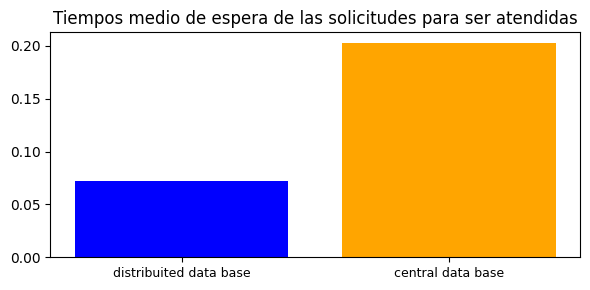

In [67]:
create_comparison_graphics(mean_waiting_time_ddb, mean_waiting_time_cdb, "Tiempos medio de espera de las solicitudes para ser atendidas")

Siguiendo con el item 2, nos pedía analizar la fraccion de solicitudes que no esperan para ser procesadas. Teniendo en cuenta el análisis anterior, lo lógico sería que las solicitudes envíadas a la base de datos distibuida sean las más propensas a no esperar para ser atendidas. Al recibir una llamada, esta tiene dos posibles bases de datos para ser atenderla y solo tendrá que esperar si llega a una base que esté atendiendo a otra. En el caso de la base de datos central solamente hay una base de datos, por lo que todas las llamadas van a la misma, generando que la probabilidad de que llegue a la base y esté ocupada es lógicamente mayor. Los resultados obtenidos concuerdan con nuestro análisis, siendo 0.90776 la fracción de slicitudes que no esperan de la base distribuida y 0.79877 para la base central. 

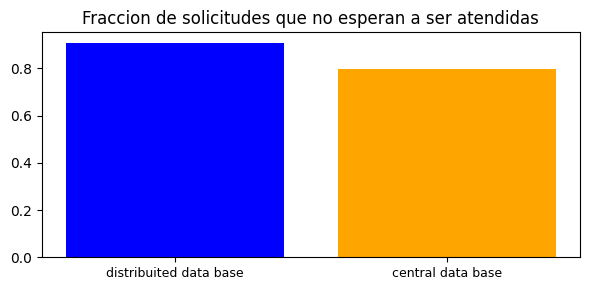

In [68]:
create_comparison_graphics(fraction_no_waiting_ddb, fraction_no_waiting_cdb, "Fraccion de solicitudes que no esperan a ser atendidas")

Por último, queremos analizar los tiempos totales de procesamiento de cada opcion de bases para ayudar a la empresa a decidir si se realiza la inversión. Sabiendo que la base de datos distribuidas tiene un tiempo menor de espera, nos queda analizar los tiempos de procesamientos de cada solicitud una vez que son atendidas. La base de datos distribuida cuenta con 2 bases: una cuyo tiempo de procesamiento es de 0,7 segundos y otra de 1 segundo. Por otro lado, la base de datos central tiene un tiempo de procesamiento de 0,8 segundos, mayor a la base 1 de la distribuida pero menor a la base 2. Las diferencias no son tan significativas y la base distribuida se compensa teniendo dos bases que distribuyen las solicitudes, yendo con mayor probabilidad a aquella con menor tiempo de procesamiento. 
Siendo que los tiempos de espera son significativamente mayor en la base central y los tiempos de procesamiento no difiren tanto, el tiempo total de procesamiento será mayor en esta opción con una única base de datos. 

Los resultados obtenidos demuestran lo concluido, siendo 0.7755117636969422 el tiempo total de procesamiento apra la base de datos distribuida y 1.0061463757360363 para la base central. Pero entonces, que decide la empresa? Sabiendo que su decisión radica en que el tiempo de la BDD sea 50% menor a la central, optará por seguir utilizando la base de datos central.  

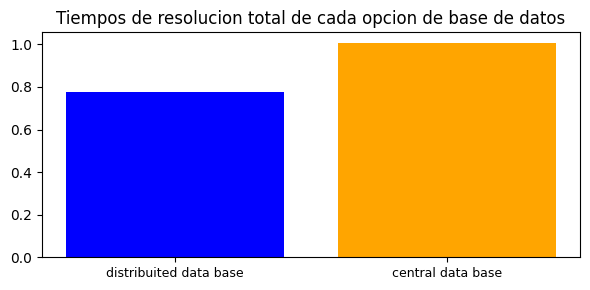

In [69]:
create_comparison_graphics(mean_total_resolving_time_ddb, mean_total_resolving_time_cdb, "Tiempos de resolucion total de cada opcion de base de datos")

# Casos con otras frecuencias

### Caso con más frecuencia de arribos

In [70]:
FASTER_ARRIVAL_CALL = 1

In [72]:
# DATOS BASE DE DATOS DISTRIBUIDA
mean_waiting_time_frec1_ddb, _, _ = create_and_run_web_service(mean_process_times,  "BASE DE DATOS DISTRIBUIDA con mayor frecuencia de arribos", central=False, arrival_call=FASTER_ARRIVAL_CALL)

BASE DE DATOS DISTRIBUIDA
el tiempo medio de espera es 0.4161555653468479
la fraccion de los que no esperan es 0.63467
el tiempo medio del total de resolucion es 1.1192359887939862


In [73]:
# DATOS BASE DE DATOS CENTRAL
mean_waiting_time_frec1_cdb, _, _ = create_and_run_web_service(mean_process_times,  "BASE DE DATOS CENTRAL con menor frecuencia de arribos", central=True, arrival_call=FASTER_ARRIVAL_CALL)

BASE DE DATOS DISTRIBUIDA
el tiempo medio de espera es 3.2125141918153806
la fraccion de los que no esperan es 0.19785
el tiempo medio del total de resolucion es 4.016034675754976


### Caso con menor frecuencia de arribos

In [74]:
SLOWER_ARRIVAL_CALL = 7

In [77]:
# DATOS BASE DE DATOS DISTRIBUIDA
mean_waiting_time_frec7_ddb, _, _ = create_and_run_web_service(mean_process_times,  "BASE DE DATOS DISTRIBUIDA con menor frecuencia de arribos", central=False, arrival_call=SLOWER_ARRIVAL_CALL)

BASE DE DATOS DISTRIBUIDA con menor frecuencia de arribos
el tiempo medio de espera es 0.0401505783600253
la fraccion de los que no esperan es 0.94704
el tiempo medio del total de resolucion es 0.7432310018071637


In [79]:
# DATOS BASE DE DATOS CENTRAL
mean_waiting_time_frec7_cdb, _, _ = create_and_run_web_service(mean_process_times,  "BASE DE DATOS CENTRAL con menor frecuencia de arribos", central=True, arrival_call=SLOWER_ARRIVAL_CALL)

BASE DE DATOS CENTRAL con menor frecuencia de arribos
el tiempo medio de espera es 0.10522524349940184
la fraccion de los que no esperan es 0.8846
el tiempo medio del total de resolucion es 0.9087457274389973


### Analizamos los resultados obtenidos y graficamos

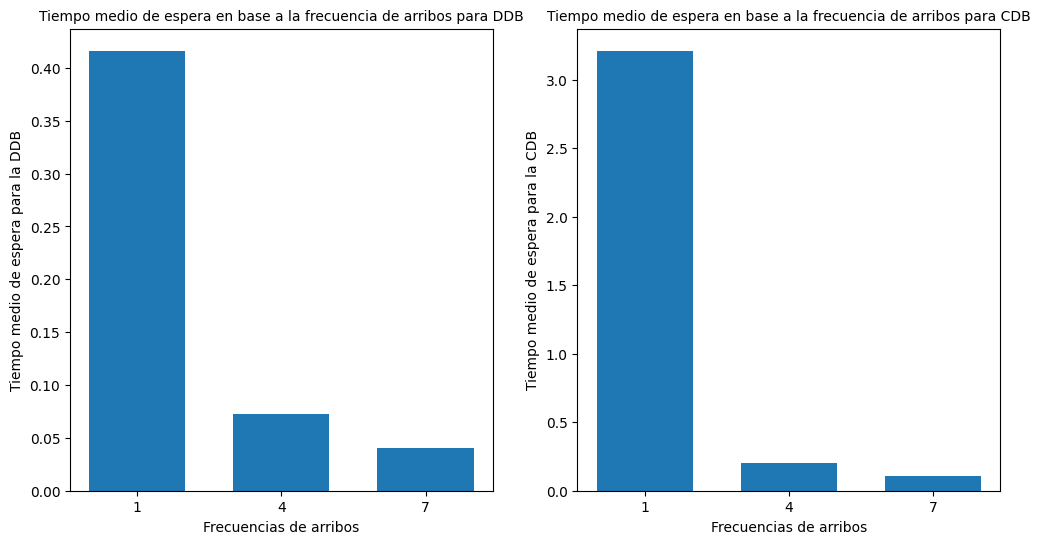

In [80]:
# Graficamos los tiempos medios de espera para cada frecuencia
frequencies = [FASTER_ARRIVAL_CALL, MEAN_ARRIVAL_CALL, SLOWER_ARRIVAL_CALL]
mean_arrival_times_ddb_freq = [mean_waiting_time_frec1_ddb, mean_waiting_time_ddb, mean_waiting_time_frec7_ddb]
mean_arrival_times_cdb_freq = [mean_waiting_time_frec1_cdb, mean_waiting_time_cdb, mean_waiting_time_frec7_cdb]

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

# Grafico de barras para la base de datos distribuida
axes[0].bar(frequencies, mean_arrival_times_ddb_freq, width=2)
axes[0].set_xticks(frequencies)
axes[0].set_ylabel('Tiempo medio de espera para la DDB')
axes[0].set_xlabel('Frecuencias de arribos')
axes[0].set_title("Tiempo medio de espera en base a la frecuencia de arribos para DDB", fontsize=10)
# Grafico de barras para la base de datos central
axes[1].bar(frequencies, mean_arrival_times_cdb_freq, width=2)
axes[1].set_xticks(frequencies)
axes[1].set_ylabel('Tiempo medio de espera para la CDB')
axes[1].set_xlabel('Frecuencias de arribos')
axes[1].set_title("Tiempo medio de espera en base a la frecuencia de arribos para CDB", fontsize=10)

plt.show()

Gráficamente podemos comprobar lo esperado, el tiempo de espera a medida que el tiempo medio de arribos va disminuyendo (menos tiempo entre arribos) aumenta. Esto se debe a que los arribos de solicitudes llegan en un menor tiempo. Por ejemplo, en el parámetro inicial llegaba una llamada cada 4 segundos, y en el caso de "FASTER_ARRIVAL_CALL" llega una llamada por segundo, generando que sean más propensas a llegar antes de que se termine de procesar la anterior, y tener que esperar. A medida que aumenta la media de arribos, va disminuyendo el tiempo de espera.

In [81]:
process_time_list_cdb = []
request_amount = 10000

for frequency in range(1, 101, 1): # frecuencias desde 1 hasta 100 con saltos de 1 (100 frec)
    # DATOS BASE DE DATOS CENTRAL
    webServiceCentral = WebService(SEED, SEED_ARRIVALS, SEED_PROCESING_TIME, request_amount, frequency, [MEAN_PROCESSING_TIME_CENTRAL_DB])
    webServiceCentral.generate_and_process_requests()
    _, act_processing_times_cdb, act_wait_times_cdb = webServiceCentral.get_info_db()
    total_time_cdb = (sum(act_processing_times_cdb) + sum(act_wait_times_cdb)) / request_amount
    process_time_list_cdb.append(total_time_cdb)

In [21]:
process_time_list_ddb = []

mean_process_times = [MEAN_PROCESSING_TIME_DB1, MEAN_PROCESING_TIME_DB2]
for frequency in range(1, 101, 1): # frecuencias desde 1 hasta 100 con saltos de 1 (100 frec)
    webServiceDistib = WebService(SEED, SEED_ARRIVALS, SEED_PROCESING_TIME, request_amount, frequency, [MEAN_PROCESSING_TIME_DB1, MEAN_PROCESING_TIME_DB2], centralDB=False, probability_d1=PROBABILITY_DB1)
    webServiceDistib.generate_and_process_requests()
    _, act_processing_times_ddb, act_wait_times_ddb = webServiceDistib.get_info_db()
    total_time_ddb = (sum(act_processing_times_ddb) + sum(act_wait_times_ddb)) / request_amount
    process_time_list_ddb.append(total_time_ddb)
    

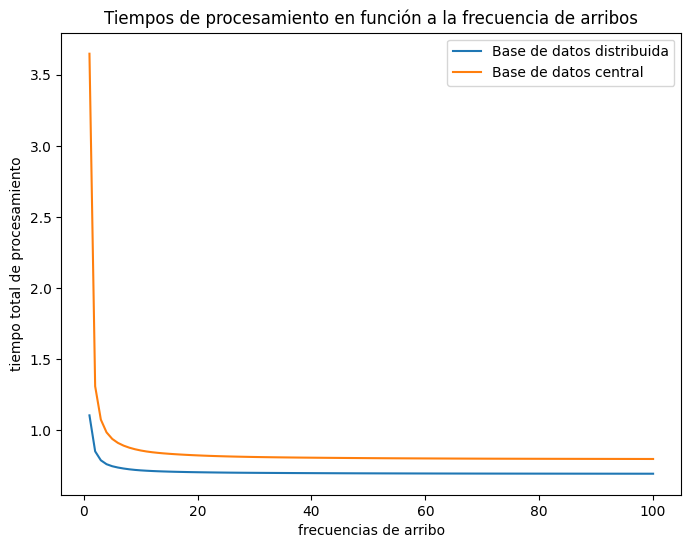

In [22]:
x = range(1, 101, 1)
y_linear = process_time_list_ddb
y_quadratic = process_time_list_cdb

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y_linear, label='Base de datos distribuida')
ax.plot(x, y_quadratic, label='Base de datos central')

ax.set_title("Tiempos de procesamiento en función a la frecuencia de arribos")
ax.set_xlabel('frecuencias de arribo')
ax.set_ylabel('tiempo total de procesamiento')
ax.legend()

plt.show()

### Base de datos con menos balance de cargas

La base de datos distribuida se veía beneficiada por tener dos bases disponibles para atender las llamadas, pero además, la base con un mejor tiempo de procesamiento era la más probable a recibir llamadas. Eso generaba que la misma cantidad de solicitudes que recibía la base central, fuese ahora atendida por dos bases distintas, donde la que tenía un mejor rendimiento era la que más solicitudes procesaba. 

Se nos ocurrió variar la probabilidad de que la base 1 de la distribuida, para ver como afectaba el rendimiento de la base. A continuación, compararemos los resultados obtenidos de aumentar y disminuir dicho factor. 

In [28]:
HIGHER_PROBABILITY_DB1 = 0.95
LOWER_PROBABILITY_DB1 = 0.3

In [33]:
# DATOS BASE DE DATOS DISTRIBUIDA
mean_process_times = [MEAN_PROCESSING_TIME_CENTRAL_DB, MEAN_PROCESING_TIME_DB2]
webServiceDistribuited = WebService(SEED, SEED_ARRIVALS, SEED_PROCESING_TIME, TOTAL_REQUEST, MEAN_ARRIVAL_CALL, mean_process_times, centralDB=False, probability_d1=HIGHER_PROBABILITY_DB1)
webServiceDistribuited.generate_and_process_requests()

mean_waiting_time_hp, fraction_no_wait_hp, total_mean_processing_time_hp = print_webservice_data(webServiceDistribuited, "BASE DE DATOS DISTRIBUIDA para una probabilidad db1 mayor")

BASE DE DATOS DISTRIBUIDA para una probabilidad db1 mayor
el tiempo medio de espera es 0.1819547799901231
la fraccion de los que no esperan es 0.81794
el tiempo medio del total de resolucion es 0.9854752639297185


In [34]:
# DATOS BASE DE DATOS DISTRIBUIDA
mean_process_times = [MEAN_PROCESSING_TIME_CENTRAL_DB, MEAN_PROCESING_TIME_DB2]
webServiceDistribuited = WebService(SEED, SEED_ARRIVALS, SEED_PROCESING_TIME, TOTAL_REQUEST, MEAN_ARRIVAL_CALL, mean_process_times, centralDB=False, probability_d1=LOWER_PROBABILITY_DB1)
webServiceDistribuited.generate_and_process_requests()

mean_waiting_time_lp, fraction_no_wait_lp, total_mean_processing_time_lp = print_webservice_data(webServiceDistribuited, "BASE DE DATOS DISTRIBUIDA para una probabilidad db1 menor")

BASE DE DATOS DISTRIBUIDA para una probabilidad db1 menor
el tiempo medio de espera es 0.1068172526494705
la fraccion de los que no esperan es 0.88295
el tiempo medio del total de resolucion es 0.9103377365890659


Si comparamos ambos resultados con la respuesta original, vemos que ninguna de las opciones mejoró el rendimiento de la base distribuida. Uno tendería a creer que al aumentar la probabilidad de que la base mas eficaz reciba solicitudes, la distribución del sistema mejoraría, pero esto no es así. La base 1 tiene un mejor tiempo de procesamiento, pero aumentar tanto la pribabilidad, generó que se solaparan aún más las solicitudes en dicha base, generando que la fracción de solicitudes que no esperan disminuyera. A su vez, disminuirle la probabilidad aumentó la probabilidad de que la base 2 sea quien reciba las llamdas, afectando el rendimiento de una manera muy similar en ambos casos. La probabilidad original, aseguraba que la base mas rápida recibiera mas solicitudes, pero solamente un numero aceptable, lo necesario para no acumular llamadas.

Analizamos en un gráfico de barra los resultados visualmente:

In [40]:
def compare_3_results(info_lp, original_info, info_hp, title):
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.bar(np.arange(3), [info_lp, original_info, info_hp], color=['blue', 'orange', 'green'])
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels([ "probabilidad b1 = 0.3", "probabilidad b1 = 0.6", "probabilidad b1 = 0.95"], ha="center", fontsize=7)
    ax.set_title(title)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

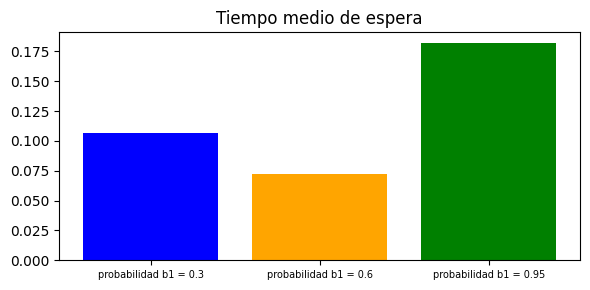

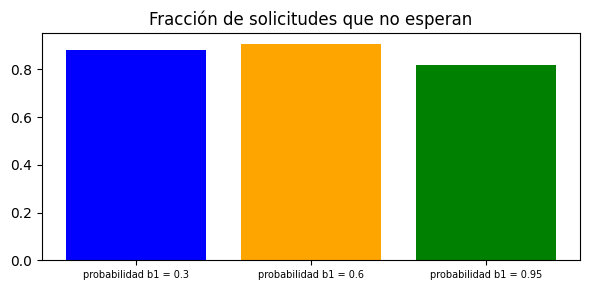

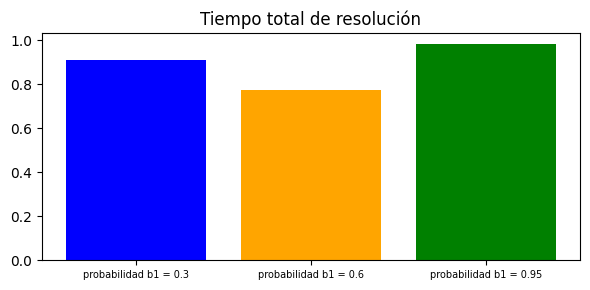

In [42]:
compare_3_results(mean_waiting_time_lp, mean_waiting_time_ddb, mean_waiting_time_hp, "Tiempo medio de espera")
compare_3_results(fraction_no_wait_lp, fraction_no_waiting_ddb, fraction_no_wait_hp, "Fracción de solicitudes que no esperan")
compare_3_results(total_mean_processing_time_lp, mean_total_resolving_time_ddb, total_mean_processing_time_hp, "Tiempo total de resolución")

Y que sucedería si combinaramos los distintos casos analizados anteriormente? Por ejemplo, si aumentamos la probabilidad de que la base 1 reciba la solicitud y aumentamos los arrivos?

In [43]:
# DATOS BASE DE DATOS DISTRIBUIDA
mean_process_times = [MEAN_PROCESSING_TIME_CENTRAL_DB, MEAN_PROCESING_TIME_DB2]
webServiceDistribuited = WebService(SEED, SEED_ARRIVALS, SEED_PROCESING_TIME, TOTAL_REQUEST, FASTER_ARRIVAL_CALL, mean_process_times, centralDB=False, probability_d1=HIGHER_PROBABILITY_DB1)
webServiceDistribuited.generate_and_process_requests()

_, _, _ = print_webservice_data(webServiceDistribuited, "BASE DE DATOS DISTRIBUIDA, aumentando probabilidad db1 y frecuencia de arribos")

BASE DE DATOS DISTRIBUIDA, aumentando probabilidad db1 y frecuencia de arribos
el tiempo medio de espera es 2.3994915997700965
la fraccion de los que no esperan es 0.27383
el tiempo medio del total de resolucion es 3.203012083709692


Si recordamos los valores obtenidos para la base distribuida con los datos originales, el tiempo medio de espera era de 0.07243134024980381. Para una frecuencia de arribos mayor, el tiempo medio de espera fue de 0.4161555653468479, y para una probabilidad db1 mayor, el tiempo medio de espera fue de 0.1819547799901231. Al comparar estos tres casos, observamos que modificar los parámetros originales afectó negativamente el rendimiento de la base.
El aumento en la frecuencia de arribos y la mayor probabilidad de db1 provocaron que las solicitudes se solapen más y que una base sea más propensa a recibir llamadas. Esto generó un incremento en el tiempo de espera para que las solicitudes sean atendidas. Al combinar ambos cambios (aumentando ambos parámetros), el resultado fue aún más desfavorable: el tiempo de espera aumentó significativamente, aproximadamente un 33% más.

Además del aumento en el tiempo de espera, se vio afectada negativamente la fracción de llamadas que no tienen que esperar, y el tiempo medio de resolución total también aumentó notablemente. Demostrando así, como se vió afectada la eficacia de la base distribuida. 

### Tiempo de procesamiento en distribuida

Un parámetro que aún no hemos modificado es la media del tiempo de procesamiento. Parece tener sentido pensar que si disminuimos el tiempo de procesamiento de la base distribuida, mejorará su rendimiento y quizá incluso la empresa se decida a aceptarlo. Primero analicemos que sucede al aumentar este parámetro para ver el efecto que tiene sobre el resultado de la base.

In [92]:
DOUBLE_MEAN_PROCESSING_TIME = MEAN_PROCESSING_TIME_CENTRAL_DB * 2

In [84]:
# DATOS BASE DE DATOS DISTRIBUIDA
mean_process_times_double = [DOUBLE_MEAN_PROCESSING_TIME, DOUBLE_MEAN_PROCESSING_TIME]
webServiceDistribuited = WebService(SEED, SEED_ARRIVALS, SEED_PROCESING_TIME, TOTAL_REQUEST, MEAN_ARRIVAL_CALL, mean_process_times_double, centralDB=False, probability_d1=PROBABILITY_DB1)
webServiceDistribuited.generate_and_process_requests()

_, _ , _ = print_webservice_data(webServiceDistribuited, "BASE DE DATOS DISTRIBUIDA para el doble de tiempo de procesamiento")

BASE DE DATOS DISTRIBUIDA para el doble de tiempo de procesamiento
el tiempo medio de espera es 0.43450212223904966
la fraccion de los que no esperan es 0.79082
el tiempo medio del total de resolucion es 2.0415430901182403


Al duplicar la media del tiempo de procesamiento de la base central y usarlo para las bases distribuidas, vemos que los resultados parecieran duplicar los obtenidos con los datos originales para la base central, excepto por la fraccion de solicitudes que no esperan. Esta ultima pareciera quedarse en la misma magnitud. Ahora usemos la mitad de la media original:

In [94]:
HALF_MEAN_PROCESSING_TIME = MEAN_PROCESSING_TIME_CENTRAL_DB / 2

In [96]:
# DATOS BASE DE DATOS DISTRIBUIDA
mean_process_times_half = [HALF_MEAN_PROCESSING_TIME, HALF_MEAN_PROCESSING_TIME]
webServiceDistribuited = WebService(SEED, SEED_ARRIVALS, SEED_PROCESING_TIME, TOTAL_REQUEST, MEAN_ARRIVAL_CALL, mean_process_times_double, centralDB=False, probability_d1=PROBABILITY_DB1)
webServiceDistribuited.generate_and_process_requests()

_, _ , mean_process_time_half = print_webservice_data(webServiceDistribuited, "BASE DE DATOS DISTRIBUIDA para la mitad de tiempo de procesamiento")

BASE DE DATOS DISTRIBUIDA para la mitad de tiempo de procesamiento
el tiempo medio de espera es 0.02294318763427082
la fraccion de los que no esperan es 0.94704
el tiempo medio del total de resolucion es 0.42470342960406854


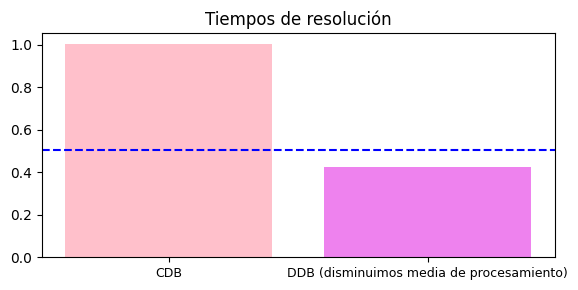

In [105]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(np.arange(2), [mean_total_resolving_time_cdb, mean_process_time_half], color=['pink', 'violet'])
ax.set_xticks(np.arange(2))
ax.axhline(y=mean_total_resolving_time_cdb / 2, color='blue', linestyle='--', label='Mitad de mean_total_resolving_time_ddb')
ax.set_xticklabels(["CDB", "DDB (disminuimos media de procesamiento)"], ha="center", fontsize=9)
ax.set_title( "Tiempos de resolución")

# Mostrar el gráfico
plt.tight_layout()
plt.show()